In [125]:
import sys
import os
import numpy as np
import cv2
from scipy.spatial.transform import Rotation
from rich import print
import yaml

# add parent folder to path
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.opencv_utils import putBText

# don't display floats in scientific notation
np.set_printoptions(suppress=True)


In [126]:
# load camera intrinsics
with open("../camera_intrinsics.yml", "r") as stream:
    try:
        camera_intrinsics = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

CAMERA_MATRIX = np.array(camera_intrinsics["camera_matrix"]["data"]).reshape((camera_intrinsics["camera_matrix"]["rows"], camera_intrinsics["camera_matrix"]["cols"]))

DIST_COEFFS = np.array(camera_intrinsics["distortion_coefficients"]["data"]).reshape((camera_intrinsics["distortion_coefficients"]["rows"], camera_intrinsics["distortion_coefficients"]["cols"]))

In [127]:
CAMERA_X_OFFSET = 0.03
CAMERA_Z_OFFSET = 0.28
CAMERA_ANGLE = np.radians(-120)

def camera_tf():
    tvec = np.array([CAMERA_X_OFFSET, 0, CAMERA_Z_OFFSET])

    camera_rvec = np.array([np.radians(-90), 0, CAMERA_ANGLE])
    r = Rotation.from_euler("ZYX",camera_rvec,degrees=False)
    rot_matrix = r.as_matrix()

    tf = np.identity(4, dtype=float)
    tf[:3, :3] = rot_matrix
    tf[:3, 3] = tvec

    return tf

In [128]:
extrinics = np.linalg.inv(camera_tf())

K = np.zeros((3, 4))
K[:3, :3] = CAMERA_MATRIX

P = K @ extrinics

def world_to_img(X_world):
    print("X_world", X_world)

    x_img = P @ X_world
    x_img = x_img / x_img[2]

    # x_img is in (x, y) where (0, 0) is in lower right
    print("x_img", x_img)
    return x_img


In [129]:
world_coords = np.array([
    [0.7, 0, 0, 1],
    [0.7, 0.4, 0, 1],
    [0.7, -0.4, 0, 1],
    [0.6, 0.4, 0, 1],
    [0.5, 0, 0, 1],
    [0.4, 0, 0, 1],
    ])

img_coords = []
for world_coord in world_coords:
    img_coord = world_to_img(world_coord)
    img_coords.append(img_coord)


X_world [0.7 0.  0.  1. ]

x_img [444.27       175.36528998   1.        ]

X_world [0.7 0.4 0.  1. ]

x_img [ 91.09182011 175.36528998   1.        ]

X_world [ 0.7 -0.4  0.   1. ]

x_img [797.44817989 175.36528998   1.        ]

X_world [0.6 0.4 0.  1. ]

x_img [ 42.82088704 214.27994333   1.        ]

X_world [0.5 0.  0.  1. ]

x_img [444.27       265.51602655   1.        ]

X_world [0.4 0.  0.  1. ]

x_img [444.27       336.02618292   1.        ]

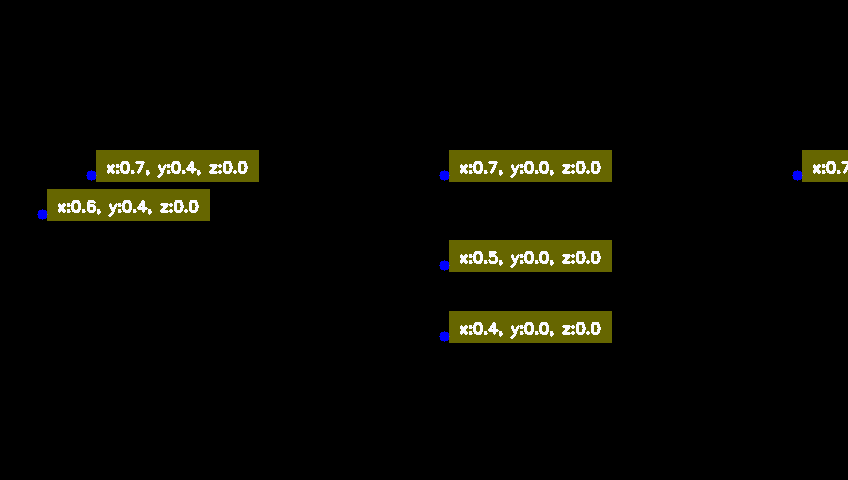

In [130]:
img = np.zeros([480,848,3],dtype=np.uint8)
img.fill(0)

for img_coord, world_coord in zip(img_coords, world_coords):
    coord_int = (int(img_coord[0]), int(img_coord[1]))
    img = cv2.circle(img, coord_int, 5, (0, 0, 255), -1)

    colour = (0, 255, 255)
    text = f"x:{np.round(world_coord[0], 2)}, y:{np.round(world_coord[1], 2)}, z:{np.round(world_coord[2], 2)}"

    img = putBText(img, text, (int(img_coord[0]) + 15, int(img_coord[1])-15), vspace=10, hspace=10, font_scale=0.5, background_RGB=colour,text_RGB=(255,250,250))

from PIL import Image
display(Image.fromarray(img))

In [133]:
# source: Zisserman pg. 157, Multiple View Geometry in Computer Vision Second Edition

M = P[:3, :3]
p_4 = P[:3, 3] # column 4

M_inv = np.linalg.inv(M)

C_tilde = -M_inv @ p_4

def img_to_world(x_img):

    x_tilde = M_inv @ x_img

    mu = float(- C_tilde[2]/x_tilde[2]) # this solves for Z=0
    X = np.squeeze(mu * x_tilde) + C_tilde

    return X


for img_coord in img_coords:
    print("img_coord", img_coord)
    world_coord_again = img_to_world(img_coord)
    print("world_coord (back again)", world_coord_again)


img_coord [444.27       175.36528998   1.        ]

world_coord (back again) [0.7 0.  0. ]

img_coord [ 91.09182011 175.36528998   1.        ]

world_coord (back again) [0.7 0.4 0. ]

img_coord [797.44817989 175.36528998   1.        ]

world_coord (back again) [ 0.7 -0.4  0. ]

img_coord [ 42.82088704 214.27994333   1.        ]

world_coord (back again) [0.6 0.4 0. ]

img_coord [444.27       265.51602655   1.        ]

world_coord (back again) [ 0.5 -0.   0. ]

img_coord [444.27       336.02618292   1.        ]

world_coord (back again) [0.4 0.  0. ]